# <span style="color:deepskyblue; font-weight:bold;">Recap</span>

<div style="text-align: justify;">
In the previous notebook, we analyzed our population in order to create clusters and then to test them with a metric. The objective of this chapter is to develop two models on each segment and compare them with a single one. We are assuming that there is an already-developed-trunk model on the entire population with the aim of having a solid benchmark. This will be important to give value to the business and to realize if the segmentation was well performed. On the same page, we have two left questions to answer, these are the following ones:
</div>

* How do granular models perform better than a single one?
* What added value does having more than a model provide to the business?

# Notebook Initialization

Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import warnings
import pickle

from category_encoders.woe import WOEEncoder
from constants.categories import category_profession
from libs.modellingFunx import gini_score

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

# libraries configuration
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# constants
TIME_ID = 'CODMES'
CLIENT_ID = 'CODSOLICITUD'
TARGET = 'FLG_DEFAULT_12M'

Reading segmented dataframe and getting initial information

In [2]:
# getting data from csv file
data = pd.read_csv('datasets/segmented_universe.csv', sep = ",")

# showing top 5
data.head()

,CODMES,CODSOLICITUD,DEUDA,PLAZO_CREDITO,FLG_GARANTIA,MIN_MES_DE_DEFAULT,FLG_DEFAULT_12M,SEGMENTOCLIENTE,TARJETA_RELACIONADA,VEHICULAR_RELACIONADA,HIPOTECARIO_RELACIONADA,ATRASO_MAXIMO_ULT_6M,ATRASO_MAXIMO_ULT_12M,ATRASO_MAXIMO_ULT_24M,MESES_AHORROS_ULT_6M,MEDIANA_AHORROS_ULT_6M,DEUDA_TOTAL_SISTEMA,CLASIF_SISTEMA_ULT_12M,FLG_PDH,NUMERO_DE_PAGOS_PDH,MONTO_TC_SISTEMA,INGRESO_CLIENTE,PROFESION,ZONA_DEL_DESEMBOLSO,ESTADO_CIVIL,EDAD_T,CUOTA,LINEA_DE_TC,MONTO_TC_MEMBRESIA,FLG_TC_VISA,FLG_TC_MC,FIXED_CLUSTER
0,201402,1,7116.681318,48,0,NaN,0,CLIENTES ORO,1,0,0,0,0.0,0.0,6.0,3772.486272,5450.35,0.0,1,24,4067.03,2526.246600,INGENIERO,UCAYALI,SOL,26.0,236.983971,5600.0,170.0,0.0,0.0,CORPUS
1,201404,2,1616.555000,60,0,NaN,0,CLIENTES ORO,1,0,0,0,0.0,0.0,6.0,8389.745000,0.00,0.0,1,24,0.00,2895.761372,TECNICO,AREQUIPA,CAS,49.0,62.089650,19250.0,170.0,0.0,0.0,CORPUS
2,201403,3,8082.775000,48,0,NaN,0,CLIENTES ORO,1,0,0,0,0.0,0.0,6.0,1842.695000,0.00,0.0,1,13,0.00,1474.419056,INGENIERO DE MINAS,PUNO,SOL,33.0,22.894893,10900.0,80.0,0.0,0.0,CORPUS
3,201307,4,10186.990760,48,0,201403.0,1,CLIENTES ORO,0,0,0,0,0.0,0.0,6.0,4514.070000,5661.25,0.0,1,24,0.00,1992.756892,TECNICO,CUZCO,SOL,25.0,244.267800,10900.0,80.0,0.0,0.0,CORPUS
4,201401,5,10777.033330,48,0,NaN,0,CLIENTES PLATINUM SEGM 2,1,0,0,0,0.0,0.0,6.0,7848.908333,0.00,0.0,1,6,0.00,1680.938223,TEC MECANICO AUTOMOTRIZ,LIMA_ESTE,CAS,57.0,17.430000,16300.0,170.0,0.0,0.0,PEAK


# <span style="color:#FF6600; font-weight:bold;">Fourth Question:</span> <span style="color:#6699CC;">How do granular models perform better than a single one?</span>

This section is quite complex because we need to generate our pre-existed benchmark, then we have to create two models on two segments. As a first step we are going to create a model on the entire universe. We are no tuning inasmuch as it is not the scope of the project, it is just to create some views part of the EDA development.

## <span style="color:lightcoral; font-weight:bold;"> Benchmark Developement:</span> <span style="color:deepskyblue;">Single Model</span>

This part has nothing to do with the clusters, it is just to develop a model on the whole universe, we need to preprocess features and to fit them into a model. As it was explained before, we are not going to each step a model should go, for instance, the tuning section.

We should see how the RD12 behaves and the materiality

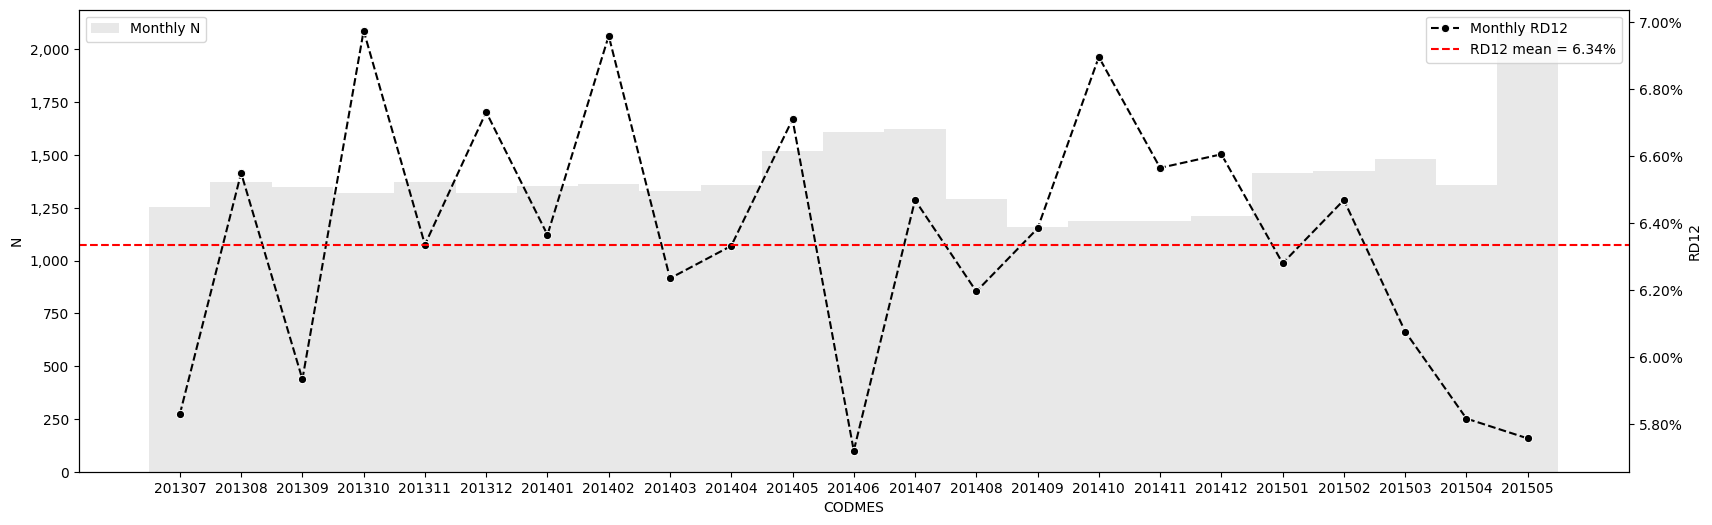

In [3]:
group = data.groupby(TIME_ID, as_index = False)\
            .agg({CLIENT_ID: 'count',
                  TARGET: 'mean'})\
            .sort_values(by = TIME_ID)\
            .rename(columns = {CLIENT_ID: 'N',
                               TARGET: 'RD12'})

group['CODMES_NUM'] = range(len(group))
# get rd mean
rd_mean = data[TARGET].mean()

# declare subplots
fig, axis = plt.subplots(figsize = (20, 6))

# create N plot
sns.barplot(data = group,
            x = 'CODMES_NUM',
            y = 'N',
            width = 1,
            color = '#D3D3D3',
            alpha = 0.5,
            label = 'Monthly N',
            ax = axis)

# create second y axis
axis_rd = axis.twinx()

# create RD12 plot
sns.lineplot(data = group,
             x = 'CODMES_NUM',
             y = 'RD12',
             color = 'black',
             marker = 'o',
             label = 'Monthly RD12',
             ls = '--',
             ax = axis_rd)

# plot RD12 mean
axis_rd.axhline(rd_mean, color = 'red', ls = '--', label = f'RD12 mean = {rd_mean:.2%}')
# format data
axis.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
axis_rd.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.2%}'))
# set labels
axis.set_xlabel(TIME_ID)
axis.set_xticks(range(len(group)))
axis.set_xticklabels(group['CODMES'])

plt.legend()
plt.show()

<span style="color:#D8B0E5; font-weight:bold;">Observations:</span>

* It can be appreciated that the N value is uniform until 201504, which means most of the data is stable in terms of observations. Last month could be used as "Out of Time" set, in fact, last three months would be useful because RD12 is decreasing. Evaluating on a low default set could challenge a lot our model.

* RD12 behaves as expected, it does not vary a lot regarding its mean on the entire universe, its values go from 5.80% to 7%, which also calls the attention to verify how much imbalaced our target is.

It is well-known that credit risk models tend to have their target imbalanced. We should check on it in order observe the materiality

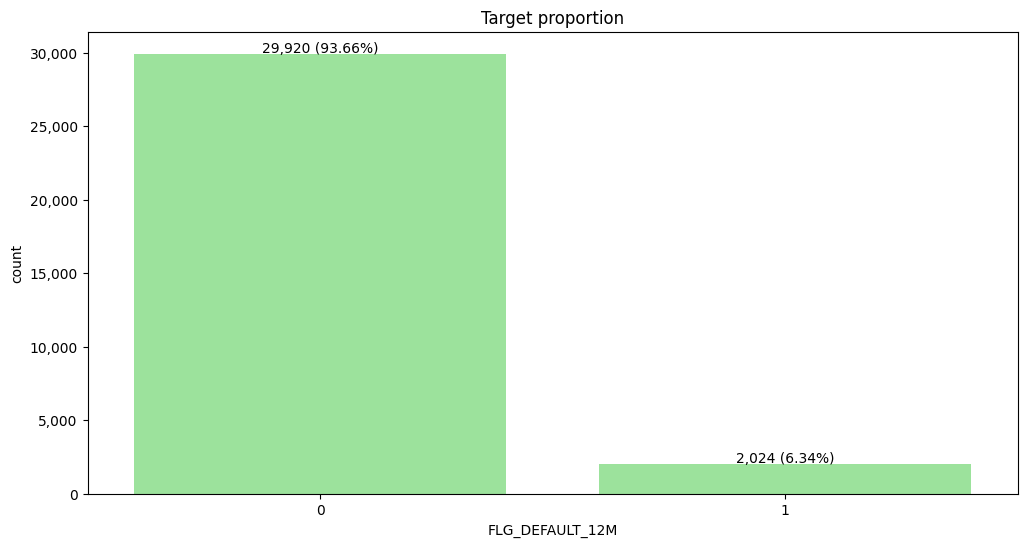

In [4]:
# create figure
plt.figure(figsize = (12, 6))

# counplot
ax = sns.countplot(data = data,
                   x = TARGET,
                   color = 'lightgreen')
# display proportions
target = data[TARGET].value_counts().to_dict()
target_per = {key: value / (sum(target.values())) for key, value in target.items()}

for x_pos in target.keys():
    plt.text(x = x_pos,
             y = target[x_pos] + 100,
             s = f'{target[x_pos]:,.0f} ({target_per[x_pos]:.2%})',
             ha = 'center')
# set title
ax.set_title('Target proportion')
# set format y axis
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.show()

<span style="color:#D8B0E5; font-weight:bold;">Observations:</span>

* As we saw in the preovious plot, the target is imbalaced, this might be a drawback when we have to develop the two left models beacuse we will reduce the materiality, having 2k samples of the target on the entire universe makes analyze that this point would be a future problema, but in terms of creating a single model, it should not be a problem.

* We are not oversampling our population, this approach uses balanced ensemble methods to handle this inconvenient.

Afterall, We have realized that our N and target is quite stable along months, however, target is pretty imbalanced on the entire dataset in terms of materiality, which could be a problem when splitting the universe. It is time to start modelling, we initiate counting unique values of categorical features, if they are greater than 15, we need to replace the categories.

In [5]:
# declare a dataset for analysis
features_to_remove = [TIME_ID, 'FIXED_CLUSTER']
data_analysis = data.drop(columns = features_to_remove)

# show describe
display(data_analysis.describe(include = object))

,SEGMENTOCLIENTE,PROFESION,ZONA_DEL_DESEMBOLSO,ESTADO_CIVIL
count,31944,31604,30954,30954
unique,7,175,30,6
top,CLIENTES ORO,TECNICO,AREQUIPA,SOL
freq,22101,10980,3664,21258


"PROFESION" and "ZONA_DEL_DESEMBOLSO" have too many unique values, before dropping them, we could regroup theri categories

In [6]:
# regroup PROFESION values for new ones
data['PROFESION'] = data['PROFESION'].map(category_profession)

# regroup ZONA_DEL_DESEMBOLSO for a pair
data['ZONA_DEL_DESEMBOLSO'] = data['ZONA_DEL_DESEMBOLSO'].fillna('')
data['ZONA_DEL_DESEMBOLSO'] = np.select([data['ZONA_DEL_DESEMBOLSO'].str.contains(pat = 'LIMA'),
                                         data['ZONA_DEL_DESEMBOLSO'] == '',
                                         ~data['ZONA_DEL_DESEMBOLSO'].str.contains(pat = 'LIMA')],
                                        ['LIMA', pd.NA, 'OTHER REGIONS'],
                                        default = pd.NA)

Now we verify new categories

In [7]:
# save dataframe
data.to_csv('datasets/segmented_universe_reg.csv', index = False)
# show describe
display(data.drop(columns = features_to_remove).describe(include = object))

,SEGMENTOCLIENTE,PROFESION,ZONA_DEL_DESEMBOLSO,ESTADO_CIVIL
count,31944,31602,30954,30954
unique,7,4,2,6
top,CLIENTES ORO,University Education,OTHER REGIONS,SOL
freq,22101,15284,15749,21258


We could complement with a further analysis but it is not our main approach. After regrouping the needed categories, we split the data into <span style="color:orange; font-weight:bold;">train</span>, <span style="color:orange; font-weight:bold;">watchlist</span>, <span style="color:orange; font-weight:bold;">test</span> and <span style="color:orange; font-weight:bold;">oot</span> sets. The split is performed using stratified sampling.



In [8]:
# select last 3 months as oot period (based on N and RD6 plot)
n_months = 3
oot_months = np.sort(data[TIME_ID].unique())[-n_months:]

# select oot set
data_oot = data[data[TIME_ID].isin(oot_months)].copy()

# select development set
data_dev = data[~data[TIME_ID].isin(oot_months)].copy()

# split development set
data_trainwatch, data_test = train_test_split(data_dev,
                                              test_size = 0.2,
                                              stratify = data_dev[['CODMES', 'FLG_DEFAULT_12M']],
                                              shuffle = True,
                                              random_state = 123)

data_train, data_watch = train_test_split(data_trainwatch,
                                          test_size = 0.3,
                                          stratify = data_trainwatch[['CODMES', 'FLG_DEFAULT_12M']],
                                          shuffle = True,
                                          random_state = 123)

# join whole dataset
data_train['SAMPLE'] = 'train'
data_watch['SAMPLE'] = 'watchlist'
data_test['SAMPLE'] = 'test'
data_oot['SAMPLE'] = 'oot'

# concatenate sets
data = pd.concat([data_train, data_watch, data_test, data_oot], axis = 0, ignore_index = True)

Before training a model, it is importan to analyse how stable the features are. This approach helps for feature selection, we are plotting the view but not grabbing selected one, we are full fitting the model with all its features.

In [9]:
# select data train and watchlist
data_analysis = data[data['SAMPLE'].isin(['train', 'watchlist'])].copy()

# select features for gini
features_to_remove = [TIME_ID, CLIENT_ID, TARGET, 
                      'MIN_MES_DE_DEFAULT', 'FIXED_CLUSTER', 'SAMPLE']

features = data_analysis.drop(columns = features_to_remove).columns.tolist()

# get woe values
encoder = WOEEncoder(handle_missing = 'return_nan',
                     handle_unknown = 'return_nan').set_output(transform = 'pandas')

cat_prep = make_column_transformer((encoder, make_column_selector(dtype_include = 'object')),
                                    remainder = 'passthrough').set_output(transform = 'pandas')

data_tr = cat_prep.fit_transform(data_analysis[features], data_analysis[TARGET])

data_tr.columns = [col.split('__')[-1] if 'woe' not in col.split('__')[0] else f"{col.split('__')[-1]}_woe"
                   for col in data_tr.columns.tolist()]

# update features
features = data_tr.columns.tolist()

# add TIME_ID and TARGET
data_tr = data_tr.join(data_analysis[[TIME_ID, TARGET]], how = 'left')

# select train and watchlist to plot gini in time
gini_in_time = data_tr.groupby('CODMES')\
                      .apply(lambda df: pd.Series({feat: gini_score(df[~df[feat].isnull()], 
                                                                    TARGET,
                                                                    feat)
                                                  for feat in features}))

Once we have the gini values, they need to be significant and stable. In order to achieve it, we should create a funnel that evaluates how good the ginis are and stable as well. We are plotting how monthly gini behaves to summarize the process.

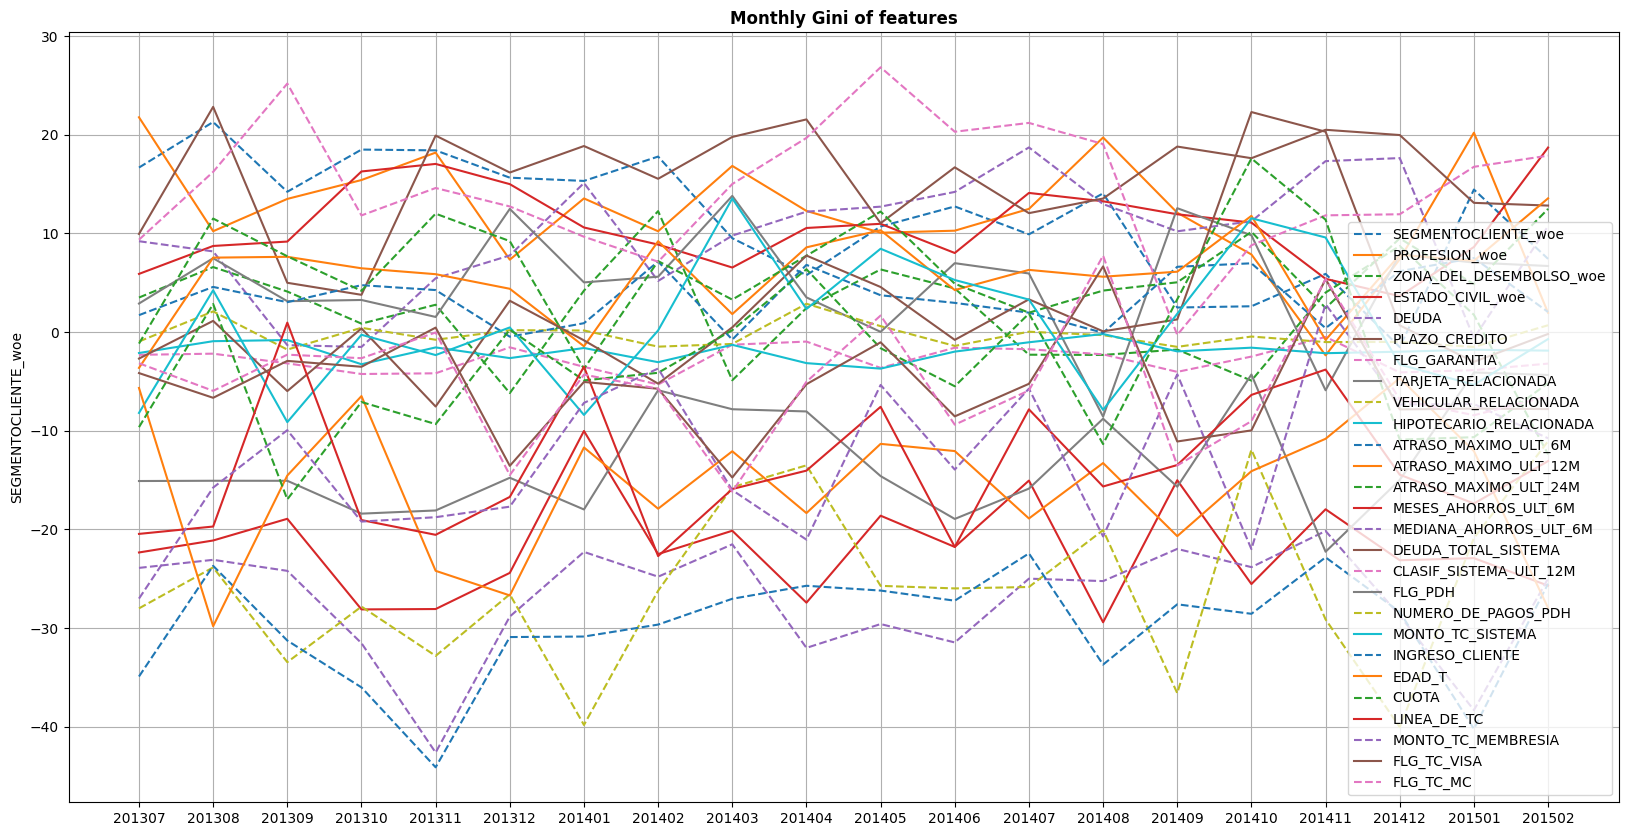

In [10]:
# get features
eval_features = gini_in_time.columns.tolist()

# reset axis
monthly_gini = gini_in_time.reset_index().copy()

# set figure
plt.figure(figsize = (20, 10))
# plot all curves on a single plot
for index, eval_feature in enumerate(eval_features):
    # plot current feature
    if index % 2 == 0:
        sns.lineplot(x = range(len(monthly_gini[TIME_ID])),
                     y = monthly_gini[eval_feature],
                     label = eval_feature,
                     ls = '--')
    else:
        sns.lineplot(x = range(len(monthly_gini[TIME_ID])),
                     y = monthly_gini[eval_feature],
                     label = eval_feature)
    # set axis
    plt.xticks(range(len(monthly_gini[TIME_ID])), monthly_gini[TIME_ID])
    
    # set title
    plt.title('Monthly Gini of features', fontdict = dict(weight = 'bold', fontsize = 12))

plt.grid()
plt.legend()    
plt.show()

<span style="color:#D8B0E5; font-weight:bold;">Observations:</span>

* We observe that not all features behave the same way each month. It is expected for them to either positive or negative throughout all the periods, nevertheless this is not the scenario.

* The unstable features should be removed because they might skew the output. In addition to this, the gini was calculated on non-null values, we are ignoring the missing rate and how good a feature with it could represent the target in terms of gini. This is also a step for processing.

Finally, we create the pipeline model to train our classifier.

In [11]:
# select data train
data_train = data[data['SAMPLE'].isin(['train'])].copy()
data_watch = data[data['SAMPLE'].isin(['watchlist'])].copy()

# get features
train_features = [feat for feat in data_train.columns.tolist() if feat not in features_to_remove + ['prediction']]

# declare encoder an passthrough class
encoder = WOEEncoder(handle_missing = 'return_nan',
                     handle_unknown = 'return_nan').set_output(transform = 'pandas')

# create preprocessing
cat_prep = make_column_transformer((encoder, make_column_selector(dtype_include = 'object')),
                                   remainder = 'passthrough',
                                   verbose_feature_names_out = False).set_output(transform = 'pandas')

# fit preprocessing
cat_prep.fit(data_train[train_features], data_train[TARGET])

# create classifier
model = XGBClassifier(objective = 'binary:logistic',
                      n_estimators = 500,
                      max_depth = 3,
                      min_child_weight = 0.01,
                      eval_metric = 'auc',
                      eta = 0.01,
                      reg_lambda = 5,
                      alpha = 25,
                      gamma = 15,
                      subsample = 0.5,
                      scale_pos_weight = np.sqrt((data_train[TARGET] == 0).sum() / (data_train[TARGET]  == 1).sum()),
                      early_stopping_rounds = 20,
                      random_state = 123)

# create pipeline
model_pipe = Pipeline([('prep', cat_prep), ('clf', model)])

# fit pipeline
model_pipe.fit(X = data_train[train_features], 
               y = data_train[TARGET],
               clf__eval_set = [(cat_prep.transform(data_watch[train_features]), 
                                 data_watch[TARGET])],
               clf__verbose = 0)

# predict values
data['prediction_single'] = model_pipe.predict_proba(data[train_features])[:, 1]

Display metrics and save them

In [14]:
# create metrics
summary = data.groupby('SAMPLE')\
              .apply(lambda df: gini_score(df, TARGET, 'prediction_single'))\
              .loc[['train', 'watchlist', 'test', 'oot']]\
              .reset_index(name = 'gini_single_model')

# save objects
with open('objects/single_model/encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)

with open('objects/single_model/cat_preprocessing.pkl', 'wb') as file:
    pickle.dump(cat_prep, file)

with open('objects/single_model/model.pkl', 'wb') as file:
    pickle.dump(model, file)

with open('objects/single_model/model_pipeline.pkl', 'wb') as file:
    pickle.dump(model_pipe, file)

# save metrics and prediction
predictions = data[[TIME_ID, CLIENT_ID, 'prediction_single']].sort_values(by = TIME_ID)\
                                                             .copy()
predictions.to_csv('results/single_model_punctuation.csv', index = False)
summary.to_csv('results/single_model_set_evaluation.csv', index = False)
display(summary)

,SAMPLE,gini_single_model
0,train,58.731886
1,watchlist,54.070890
2,test,50.982967
3,oot,53.619777


The gini results come from a naive xgboost, however, the overfitting is small, only 7 gini points and oot set is performing well, we need to observe how gini behaves along months.

In [39]:
np.argmax(gini_in_time['GINI'])

6

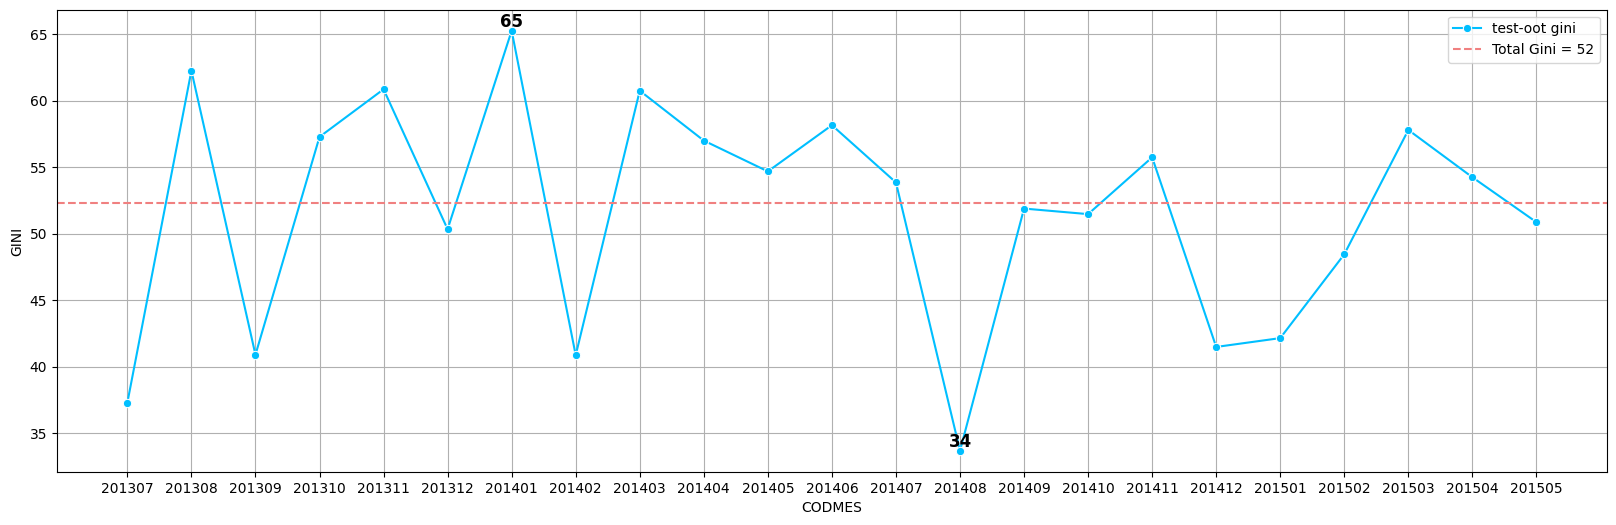

In [43]:
# get gini in time
gini_in_time = data[data['SAMPLE'].isin(['test', 'oot'])].groupby(TIME_ID, as_index = False)\
                                                         .apply(lambda df: gini_score(df, TARGET, 'prediction_single'))\
                                                         .rename(columns = {None: 'GINI'})

# plot gini in time
# declare figure
plt.figure(figsize = (20, 6))

sns.lineplot(x = range(len(gini_in_time[TIME_ID])),
             y = gini_in_time['GINI'],
             color = 'deepskyblue',
             marker = 'o',
             label = 'test-oot gini')

# add total gini
total_gini = gini_score(data[data['SAMPLE'].isin(['test', 'oot'])], TARGET, 'prediction_single')
plt.axhline(total_gini, color = 'lightcoral', ls = '--', label = f'Total Gini = {np.round(total_gini):.0f}')

# get lowest and highest gini
highest_gini = gini_in_time['GINI'].max()
lowest_gini = gini_in_time['GINI'].min()

# write only both of them
for x_pos, y_pos in zip(range(len(gini_in_time[TIME_ID])), gini_in_time['GINI']):
    if y_pos in (highest_gini, lowest_gini):
        plt.text(x = x_pos,
                 y = y_pos,
                 s = f'{np.round(y_pos):.0f}',
                 ha = 'center',
                 va = 'bottom',
                 fontdict = dict(fontsize = 12, weight = 'bold'))              
# set ticks
plt.xticks(range(len(gini_in_time[TIME_ID])), gini_in_time[TIME_ID])

# set x labels
plt.xlabel(TIME_ID)
plt.grid()
plt.legend()
plt.show()

<span style="color:#D8B0E5; font-weight:bold;">Observations and single model conclusions:</span>

* In terms of gini stability, the model performs well according to months. The general gini is closer to the highest one in contrast to the lowest value. There might be some features that are not helping the model scale as it has to, this could be treated by selecting right features, which was not part of the scope.

* We could extract the feature importances to validate if the inputs make sense regarding economics but that would be a further analysis. Nonetheless, the gini stability looks acceptable in spite of not controlling the feature's flux.

* We could say that a single model is giving impressive results, having a oot gini greatear than 50 perfectly allows the business to create the right cutoff to decide whether or not giving a loan to its clients. We are able to assure we have developed an expected model, it is not tuned though.